# CNN Regressor for Head Pose Estimation

## Overview

This Jupyter notebook demonstrates the process of building a Convolutional Neural Network (CNN) regressor to estimate head pose angles (yaw, pitch, and roll) from images. The model is trained using a sub-dataset derived from the 300W-LP dataset, specifically focusing on the head position attributes.

## Dataset Preparation

### Dataset Source
The original dataset used is the [300W-LP dataset](http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/main.htm). It contains various features, but for this project, only the head position attributes (yaw, pitch, roll) were extracted.

### Dataset Generation
A subset of the 300W-LP dataset was created using the notebook provided in this [gist](https://gist.github.com/mani3/1ec02066cb11df85cfc694cab9230bc3#file-generate-dataset-from-the300w-lp-public-ipynb). This notebook extracts the relevant head position features and prepares the data for training.

A subset of the new generated dataset is used. The regressor model is trained using only yaw angle values. 

### Dataset Splitting
The dataset was split into three subsets:
- **Training Set**: 60%
- **Testing Set**: 20%
- **Validation Set**: 20%

## Model Architecture

The CNN regressor is built using the following architecture:

```python
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
    
        Dense(1)
    ])
    
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=['mae'])


## Import all the neccesary dependencies

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# for tensorflow install https://developer.apple.com/metal/tensorflow-plugin/

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [5]:
# load the preprocessed dataset 
with open('../dataset/data_20000.npy', 'rb') as data, open('../dataset/label_20000.npy', 'rb') as label:
  dataset = np.load(data)
  print(dataset.shape)
  labels = np.load(label)
  print(labels.shape)

(20000, 128, 128, 3)
(20000, 3)


## Join both the dataset and labels into a single dataframe
This dataset contains images and their `yaw` values

In [7]:
yaw_labels = labels[:, 1] # extract the yaw value only
df = pd.DataFrame({
    'image': list(dataset),
    'label': yaw_labels
})

df.head()

,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",30.915585
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",-70.093781
2,"[[[86, 96, 98], [86, 96, 98], [85, 95, 97], [8...",-59.824131
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",77.033363
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [29, 29, 29...",-60.159260


## Split the dataset into training, testing and validation

In [8]:
validation_split = 0.4

num_train_samples = int((1 - validation_split) * len(df))
testing = df[num_train_samples:]
training = df[:num_train_samples]

num_validation_samples = int(len(testing) * 0.5)
testing = testing[num_validation_samples:]
validation = testing[:num_validation_samples]

print(f'Training: {training.shape[0]}')
print(f'Testing: {testing.shape[0]}')
print(f'Validation: {validation.shape[0]}')

Training: 12000
Testing: 4000
Validation: 4000


## Define training, testing and validation data
The images are already in grayscale, so no need to reshape them

In [31]:
# x values
x_training = training['image']
x_testing = testing['image']
x_validation = validation['image']

# y values
y_training = training['label']
y_testing = testing['label']
y_validation = validation['label']

x_training = np.array([np.array(xi).astype(np.float32) for xi in x_training])
y_training = np.array([np.array(yi).astype(np.float32) for yi in y_training])
x_validation = np.array([np.array(xi).astype(np.float32) for xi in x_validation])
y_validation = np.array([np.array(yi).astype(np.float32) for yi in y_validation])
x_testing = np.array([np.array(xi).astype(np.float32) for xi in x_testing])

## Define the model architecture
This function builds a regressor based on a CNN architecture that takes as input an image and the output is a yaw value

In [14]:
def create_model(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
    
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=MeanSquaredError(),
                  metrics=['mae'])
    return model

## Create a model instance, add early stop and reduce learning rate on performance degradation

In [40]:
model = create_model()
early_stopping = EarlyStopping(
    monitor = 'val_loss',        # Monitor validation loss
    patience = 5,                # Stop after 5 epochs with no improvement
    min_delta = 0.001,           # Consider improvements greater than 0.001
    mode = 'min',                # We want to minimize the loss
    restore_best_weights = True  # Restore the best model weights
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

/Users/albertxcastro/miniforge3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Add data augmentation ro reduce overfitting

In [41]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_training)
train_generator = datagen.flow(x_training, y_training, batch_size=32)
steps_per_epoch = len(x_training) // 32

## Train the model

In [42]:
history = model.fit(
    x_training,
    y_training,
    epochs = 25,
    validation_data = (x_validation, y_validation),
    callbacks = [early_stopping, reduce_lr]
)

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 1265.0566 - mae: 26.9211 - val_loss: 269.2658 - val_mae: 12.5066 - learning_rate: 0.0010
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 386.6310 - mae: 15.1725 - val_loss: 180.5796 - val_mae: 10.2378 - learning_rate: 0.0010
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 273.9228 - mae: 12.6107 - val_loss: 116.8725 - val_mae: 8.1301 - learning_rate: 0.0010
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 213.9266 - mae: 11.1449 - val_loss: 106.5149 - val_mae: 7.7715 - learning_rate: 0.0010
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 175.1413 - mae: 10.0834 - val_loss: 67.3838 - val_mae: 5.9885 - learning_rate: 0.0010
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 169.9853 - mae: 9.8940 - val_loss: 110.3460 - val_mae: 8.0132 - learning_rate: 0.0010
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 173.1649 - mae: 9.9020 - val_loss: 64.2163 

## Print the model's summary

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,378,437 (24.33 MB)

 Trainable params: 2,126,145 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,252,292 (16.22 MB)

## Persist the trained model

In [25]:
model.save('../models/yaw_angle_regressor.keras')

## Get the model's metrics

In [43]:
model_metrics = pd.DataFrame(model.history.history)
model_metrics

,loss,mae,val_loss,val_mae,learning_rate
0,713.043945,20.145536,269.265778,12.506596,0.0010
1,347.302826,14.394940,180.579636,10.237814,0.0010
2,261.556519,12.320607,116.872490,8.130067,0.0010
3,206.364639,10.942333,106.514870,7.771459,0.0010
4,178.450500,10.165654,67.383842,5.988485,0.0010
5,168.344849,9.871496,110.346046,8.013227,0.0010
6,164.117081,9.712539,64.216255,5.753270,0.0010
7,151.730377,9.318585,63.820095,5.947345,0.0010
8,141.889389,8.942225,55.734901,5.378541,0.0010
9,143.424484,8.983497,64.592911,5.576505,0.0010


## Plot training vs validation loss and MAE

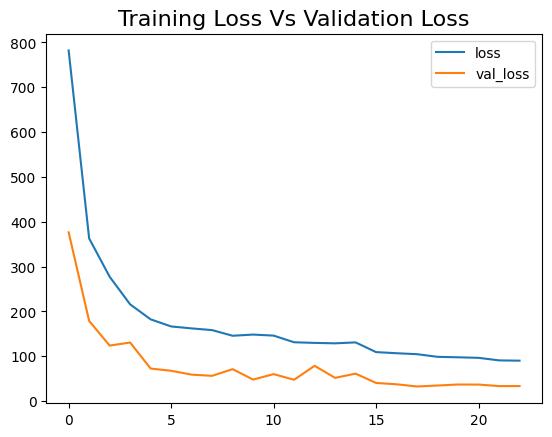

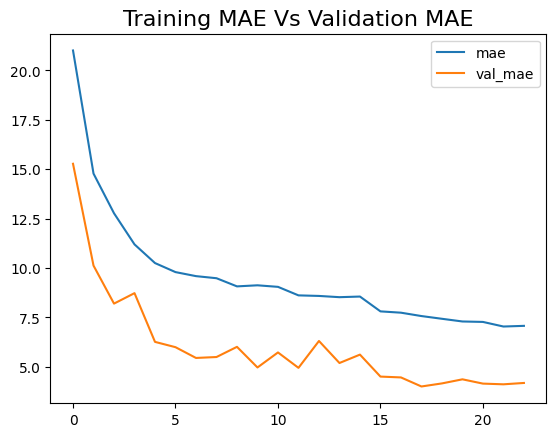

In [29]:
def plotMetricsLoss(metrics):
    metrics[['loss', 'val_loss']].plot()
    plt.title('Training Loss Vs Validation Loss', fontsize=16)
    plt.show()
    
def plotMetricsMae(metrics):
    metrics[['mae', 'val_mae']].plot()
    plt.title('Training MAE Vs Validation MAE', fontsize=16)
    plt.show()
    
plotMetricsLoss(model_metrics)
plotMetricsMae(model_metrics)

## Get the prediction values for the testing sub dataset

In [32]:
predictions = model.predict(x_testing)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


## Get statisticts from the predicted values and the labels in the testing dataset

In [33]:
mae = mean_absolute_error(y_testing, predictions)
mse = mean_squared_error(y_testing, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_testing, predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

MAE: 4.004387378692627
MSE: 32.604713439941406
RMSE: 5.71005392074585
R-squared: 0.9890125755167665


## Plot the regression line in a scatterplot

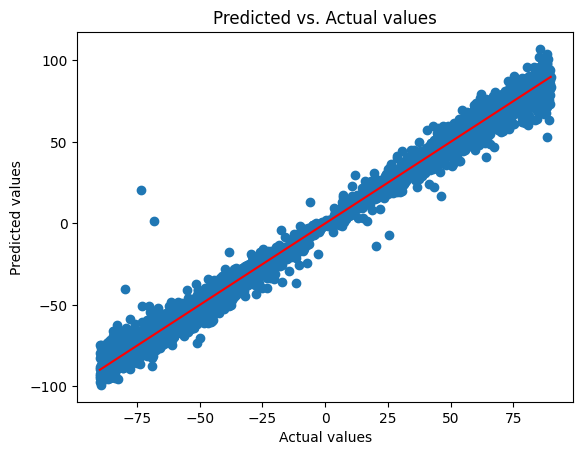

In [36]:
plt.scatter(y_testing, predictions)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs. Actual values')
plt.plot([min(y_testing), max(y_testing)], [min(y_testing), max(y_testing)], color='red')
plt.show()

## Testing the model with an unseen image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
TRUE VALUE -27.539768
PREDICTION -26.88213


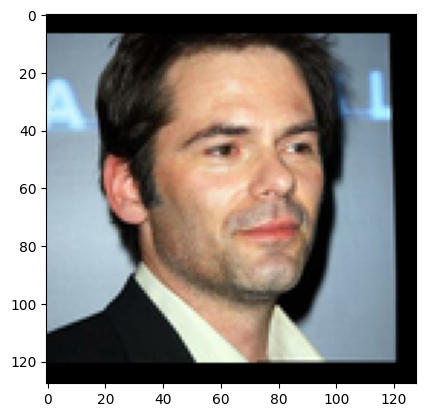

In [39]:
# index = 1400
index = 1
img = x_testing[index]
img_clipped = np.clip(img, 0, 255)

plt.imshow(img_clipped.astype(np.uint8))

prediction = model.predict(img_clipped.reshape(1, 128, 128, 3))
predictionIndex = prediction[0]
print('TRUE VALUE', y_testing[16000 + index])
print('PREDICTION', prediction[0][0])